## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card
* Bank account services
* Theft/Dispute reporting
* Mortgages/loans
* Others 


1. With the help of topic modelling, you will be able to map each ticket onto its respective department/category. 
2. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department. At least any 3 models from logistic regression, naive Bayes, decision tree and random forest need to be tried and need to select the model that performs the best according to the evaluation metrics.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()

COLAB = True

In [3]:
import missingno as msno

SAMPLE_SIZE = 1000 #1000 # 100
SAMPLE_INDEX =  316 # 36

def percent(val, total):
    return round(100 * val/total, 2)
    
def getDFInfo(df_):
    print(f"ROWS: {df_.shape[0]}, COLUMNS: {df_.shape[1]}"); print(f"COLUMNS: {df_.columns.tolist()}")
    print(f"\nMISSING DATA: {percent(df_.isnull().sum().sum(), (df_.shape[0]*df_.shape[1]))}%")

def roundOff(value):
    #print(type(value))
    return (value/1000000).round(1)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file 
if COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    f = open("/content/gdrive/My Drive/Colab Notebooks/complaints.json", "r")# Write the path to your data file and load it 
else:
    f = open("complaints.json", "r")# Write the path to your data file and load it 

print(f.name, type(f))
# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/complaints.json <class '_io.TextIOWrapper'>


## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
df[['_source.issue', '_source.sub_issue', '_source.complaint_what_happened']].head()

,_source.issue,_source.sub_issue,_source.complaint_what_happened
0,Attempts to collect debt not owed,Debt is not yours,
1,Written notification about debt,Didn't receive enough information to verify debt,Good morning my name is XXXX XXXX and I apprec...
2,"Other features, terms, or problems",Problem with rewards from credit card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Trouble during payment process,None,
4,Fees or interest,Charged too much interest,


In [10]:
df['_source.issue'].head()

0     Attempts to collect debt not owed
1       Written notification about debt
2    Other features, terms, or problems
3        Trouble during payment process
4                      Fees or interest
Name: _source.issue, dtype: object

In [11]:
df[ '_source.sub_issue'].head()

0                                   Debt is not yours
1    Didn't receive enough information to verify debt
2               Problem with rewards from credit card
3                                                None
4                           Charged too much interest
Name: _source.sub_issue, dtype: object

In [12]:
df['_source.complaint_what_happened'].head()

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                     
4                                                     
Name: _source.complaint_what_happened, dtype: object

In [13]:
#Assign new column names
df.rename(columns = {'_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


BEFORE: 57241 0 21072
AFTER: 0 57241 78313


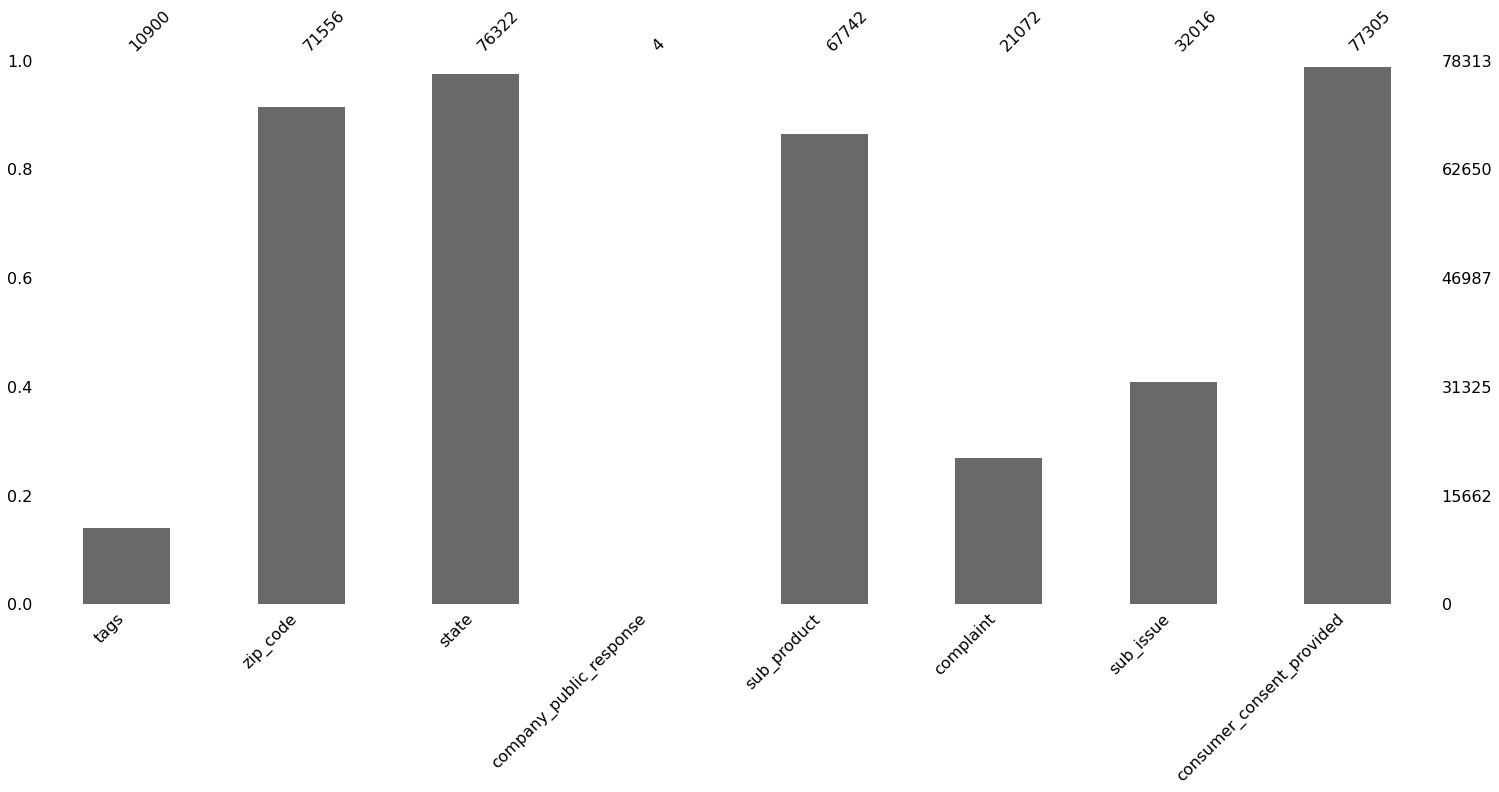

In [14]:
#Assign nan in place of blanks in the complaints column
print(f"BEFORE: {df[df['complaint']==''].shape[0]} {df[df['complaint'].isnull()]['complaint'].shape[0]} {df[~(df['complaint']=='')].shape[0]}")
df['complaint'].replace('', np.NaN, inplace=True)
print(f"AFTER: {df[df['complaint']==''].shape[0]} {df[df['complaint'].isnull()]['complaint'].shape[0]} {df[~(df['complaint']=='')].shape[0]}")
msno.bar(df[df.columns[df.isnull().any()]])

In [15]:
#Remove all rows where complaints column is nan
print(f"BEFORE: {df.shape[0]}")
df = df[~df['complaint'].isnull()]
df.reset_index(inplace=True)
print(f"AFTER: {df.shape[0]}")

BEFORE: 78313
AFTER: 21072


## TODO: SELECT ONLY A SMALL SAMPLE
To undo later

In [16]:
#if COLAB == False: 
df = df.head(1000)
print(df.shape[0])

1000


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


#### Make the text lowercase

In [17]:
# Make the text lowercase
print(f"BEFORE: {df['complaint'][SAMPLE_INDEX][:40]}")
df['complaint'] = df['complaint'].str.lower()
print(f"AFTER: {df['complaint'][SAMPLE_INDEX][:40]}")

BEFORE: My father in-law did my taxes and had th
AFTER: my father in-law did my taxes and had th


#### Remove text in square brackets, punctuation, words containing numbers

In [18]:
# REG EXPRESSIONS
REG_TEXT_IN_SQ_BRKTS = r'\[.+?\]'
REG_PUNCT = r'[^\w\s]'
REG_WORD_WITH_NUM = r'[\w]*\d[\w]*'

In [19]:
# Test Reg expressions on a sample text
TEXT = 'Sreedevi he[ll]o!! see23y[5ou] Goodday'
re.findall(REG_TEXT_IN_SQ_BRKTS, TEXT)

['[ll]', '[5ou]']

In [20]:
# Test the reg expression on the text in the dataframe
s2 = df.loc[SAMPLE_INDEX, 'complaint']; print("Before Substitution:", len(s2), s2[0:20])
s2 = re.sub(REG_TEXT_IN_SQ_BRKTS, '', s2); print("REG_TEXT_IN_SQ_BRKTS", len(s2), s2[0:20])
s2 = re.sub(REG_PUNCT, '', s2); print("REG_PUNCT", len(s2), s2[0:20])
s2 = re.sub(REG_WORD_WITH_NUM, '', s2); print("REG_WORD_WITH_NUM", len(s2), s2[0:20]) #s2

Before Substitution: 545 my father in-law did
REG_TEXT_IN_SQ_BRKTS 545 my father in-law did
REG_PUNCT 524 my father inlaw did 
REG_WORD_WITH_NUM 512 my father inlaw did 


In [21]:
DICT_REG = {'REG_TEXT_IN_SQ_BRKTS':REG_TEXT_IN_SQ_BRKTS, 'REG_PUNCT':REG_PUNCT, 'REG_WORD_WITH_NUM':REG_WORD_WITH_NUM}
for desc, reg in DICT_REG.items():
    df_reg = df[df['complaint'].str.contains(reg, regex=True)]['complaint']
    if df_reg.shape[0] == 0: continue
    
    print(desc, df_reg.shape[0])
    sample = df_reg.head().tolist()[0]

    print("BEFORE substitution")
    idx = df_reg.index[0]
    sample = df.loc[idx, 'complaint']
    print(idx, sample[:20])

    hits = re.findall(reg, sample)
    print(len(hits))
    [print(hit) for hit in hits]

    # Substitute
    df['complaint'] = df['complaint'].replace(reg, '', regex=True)

    print();print("AFTER substitution")
    df_reg = df[df['complaint'].str.contains(reg, regex=True)]['complaint']
    samples = df_reg.head().tolist()
    if len(samples) > 0:
        sample = samples[0]
        idx = df_reg.index[0]
        sample = df.loc[idx, 'complaint']
        print(idx, sample[:20])

        hits = re.findall(reg, sample)
        print(len(hits))
        [print(hit) for hit in hits]
    else:
        print("No hits")

    print("\n")

REG_TEXT_IN_SQ_BRKTS 9
BEFORE substitution
131 re : complaint again
12
[ t ]
[ fico scores, xxxx, xxxx and xxxx, respectively ]
[ 1427 -3272.9 ]
[ 1708 1725 ]
[ cc and her supervisor, mr. xxxx xxxx eventually, executive director, mr. xxxx xxxx ]
[ 8000 - 22980 ]
[ 11000 - 15986 ]
[ 1290012996 ]
[ 12925-12928 ]
[ 1 ]
[ which we did ]
[ 2 trusted agents of jp morgan chase ]

AFTER substitution
No hits


REG_PUNCT 992
BEFORE substitution
0 good morning my name
7
.
.
.
.
.
#
.

AFTER substitution
No hits


REG_WORD_WITH_NUM 809
BEFORE substitution
0 good morning my name
1
2018

AFTER substitution
No hits




In [22]:
df[df['complaint'].str.contains(REG_TEXT_IN_SQ_BRKTS, regex=True)]['complaint'].shape[0],               \
        df[df['complaint'].str.contains(REG_PUNCT, regex=True)]['complaint'].shape[0],                  \
            df[df['complaint'].str.contains(REG_WORD_WITH_NUM, regex=True)]['complaint'].shape[0],

(0, 0, 0)

####  Lemmatize the texts

In [23]:
# Write your function to Lemmatize the texts
### import necessary libraries
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
#nltk.download('omw-1.4')

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens if not token in set(stopwords.words('english'))]
    return lemmatized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df['complaint'].head()

0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in  and was told ...
2    chase card was reported on  however fraudulent...
3    on  while trying to book a xxxx  xxxx  ticket ...
4    my grand son give me check for  i deposit it i...
Name: complaint, dtype: object

In [25]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaint'] = df['complaint']
df_clean['complaint_lemma'] = df_clean['complaint'].progress_apply(lambda x: lemmatize(x))

100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]


In [26]:
df_clean.head()

,complaint,complaint_lemma
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ..."
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr..."
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a..."
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros..."
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco..."


In [27]:
print(df['complaint'].head(1).values[0])
' '.join(lemmatize(df['complaint'].head(1).values[0]))

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help


'good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help'

#### Use POS tags to get relevant words from the texts.

In [28]:
TRACE_IN_N_LINES = 200
def printOnceInNTimes(msg, count):
    #print(msg, count, onceIn)
    if count%TRACE_IN_N_LINES == 0: print(msg)

In [29]:
df_clean.shape

(1000, 2)

In [30]:
# Write your function to extract the POS tags 

'''
Out of all the POS tags, we 
need:           ADJ, ADV, NOUN, PROPN, VERB
do not need:    ADP, PUNCT, AUX, SYM, INTJ, CCONJ, X, DET, NUM, PART, PRON, SCONJ
'''

# RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'] # 0
# RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN', 'PROPN'] # 1
RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN'] # 2
# RELEVANT_POS_TAGS = ['NOUN', 'PROPN'] # 3

# shorten the pipline loading
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

count = 0
#for review in tqdm(df_clean['complaint_lemma'].to_list()[0:1000]):
RELEVANT_WORDS = []
POS_TAGS = {}
for index, row in tqdm(df_clean.iterrows()):
    relevant_words = []
    count += 1
    review = row['complaint_lemma']
    printOnceInNTimes(f"{count}: LEMMA: {review[:20]}", count)

    review = ' '.join(review)
    doc = nlp(review)
    for tok in doc:
        POS_TAGS[tok.pos_] = 1
        if tok.pos_ in RELEVANT_POS_TAGS: relevant_words.append(tok.lemma_)

    printOnceInNTimes(f"RELEVANT_WORDS: {relevant_words[:40]}", count)
    relevant_words = " ".join(relevant_words)
    printOnceInNTimes(f"RELEVANT_WORDS: {relevant_words[:40*10]}", count)

    RELEVANT_WORDS.append(relevant_words)
    printOnceInNTimes("", count)

print(POS_TAGS.keys())
df_clean['complaint_POS_removed'] = RELEVANT_WORDS

207it [00:03, 54.52it/s]

200: LEMMA: ['computer', 'purchased', 'amazon', 'item', 'defective', 'returned', 'day', 'via', 'xxxx', 'tracking', 'number', 'xxxx', 'item', 'initially', 'refunded', 'well', 'credit', 'card', 'charged', 'item']
RELEVANT_WORDS: ['item', 'day', 'tracking', 'number', 'item', 'initially', 'credit', 'card', 'item', 'downhill', 'dispute', 'submit', 'information', 'return', 'item', 'response', 'favor', 'seller', 'idea', 'even', 'dispute', 'letter', 'online', 'know', 'dispute', 'recall', 'chase', 'online', 'letter', 'case', 'promptly', 'documentation', 'month', 'somehow', 'dispute', 'information', 'letter', 'chase', 'charge', 'valid']
RELEVANT_WORDS: item day tracking number item initially credit card item downhill dispute submit information return item response favor seller idea even dispute letter online know dispute recall chase online letter case promptly documentation month somehow dispute information letter chase charge valid speaking valid tracking information initial time frame initial

402it [00:06, 56.74it/s]

400: LEMMA: ['jp', 'morgan', 'chase', 'erroneously', 'charged', 'end', 'lease', 'even', 'traded', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'pull', 'ahead', 'program', 'xxxx', 'xxxx', 'dealer', 'one']
RELEVANT_WORDS: ['erroneously', 'end', 'lease', 'even', 'program', 'dealer', 'dealer', 'damage', 'opportunity', 'pre', 'inspection', 'therefore', 'transaction', 'immediately', 'statement', 'liability', 'lease', 'dispute', 'letter', 'picture', 'lease', 'deal', 'dealer', 'total', 'deal', 'advantage', 'manufacturer', 'ahead', 'program', 'monthly', 'payment', 'excess', 'wear', 'tear', 'picture', 'inclusive', 'transaction', 'shady', 'however', 'damaging']
RELEVANT_WORDS: erroneously end lease even program dealer dealer damage opportunity pre inspection therefore transaction immediately statement liability lease dispute letter picture lease deal dealer total deal advantage manufacturer ahead program monthly payment excess wear tear picture inclusive transaction shady however damaging thing credit prequal

605it [00:10, 39.05it/s]

600: LEMMA: ['greeting', 'trying', 'get', 'loan', 'modification', 'past', 'year', 'tried', 'work', 'lawyer', 'bank', 'bank', 'mailed', 'check', 'xxxx', 'returned', 'called', 'offered', 'xxxx', 'cash']
RELEVANT_WORDS: ['loan', 'modification', 'year', 'work', 'lawyer', 'check', 'cash', 'wire', 'transfer', 'hung', 'phone', 'twice', 'payout', 'taxpayer', 'business', 'thief', 'paperwork', 'court', 'several', 'year', 'hard', 'money', 'care', 'last', 'investment', 'demand', 'follow', 'law', 'home', 'loan', 'accountable', 'went', 'street', 'stole', 'purse', 'fine', 'business', 'usual', 'congressman', 'vote']
RELEVANT_WORDS: loan modification year work lawyer check cash wire transfer hung phone twice payout taxpayer business thief paperwork court several year hard money care last investment demand follow law home loan accountable went street stole purse fine business usual congressman vote american people home loan modification today time attention least agency right



804it [00:15, 34.82it/s]

800: LEMMA: ['xxxxxxxx', 'called', 'spoke', 'chase', 'auto', 'fiance', 'account', 'number', 'xxxx', 'explained', 'called', 'requested', 'billing', 'extension', 'one', 'month', 'granted', 'health', 'hospital', 'would']
RELEVANT_WORDS: ['account', 'number', 'billing', 'extension', 'month', 'health', 'hospital', 'month', 'extension', 'extension', 'however', 'due', 'date', 'month', 'also', 'payment', 'original', 'due', 'date', 'statement', 'hospital', 'back', 'agent', 'statement', 'medical', 'emergency', 'late', 'fee', 'amount', 'supervisor', 'name', 'payment', 'fee', 'original', 'due', 'date', 'month', 'supervisor', 'xxxx', 'situation']
RELEVANT_WORDS: account number billing extension month health hospital month extension extension however due date month also payment original due date statement hospital back agent statement medical emergency late fee amount supervisor name payment fee original due date month supervisor xxxx situation account current due date month circumstance credit late

1000it [00:21, 45.87it/s]

1000: LEMMA: ['long', 'story', 'short', 'currently', 'indiana', 'hardest', 'hit', 'program', 'chase', 'bank', 'put', 'illegal', 'judgement', 'investigation', 'claimed', 'defaulted', 'program', 'called', 'confirm', 'completed']
RELEVANT_WORDS: ['long', 'story', 'short', 'currently', 'hardest', 'program', 'illegal', 'judgement', 'investigation', 'program', 'dollar', 'check', 'catch', 'patent', 'take', 'catch', 'addition', 'insurance', 'policy', 'state', 'also', 'policy', 'year', 'notice', 'homeless', 'also', 'mortgage', 'document', 'illegal', 'foreclosure']
RELEVANT_WORDS: long story short currently hardest program illegal judgement investigation program dollar check catch patent take catch addition insurance policy state also policy year notice homeless also mortgage document illegal foreclosure

dict_keys(['ADJ', 'NOUN', 'PROPN', 'VERB', 'ADV', 'DET', 'ADP', 'SCONJ', 'INTJ', 'PRON', 'NUM', 'X', 'AUX', 'PART', 'CCONJ', 'PUNCT', 'SYM'])


In [31]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
'''df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]
df_clean.drop(labels='pos_tags',axis=1,inplace=True)'''

"df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]\ndf_clean.drop(labels='pos_tags',axis=1,inplace=True)"

In [32]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
print(df_clean.shape); df_clean.head()

(1000, 3)


,complaint,complaint_lemma,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name chase debt verification stat...
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",card agent anniversary date agent wrong inform...
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",son check account never money grand son clear ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

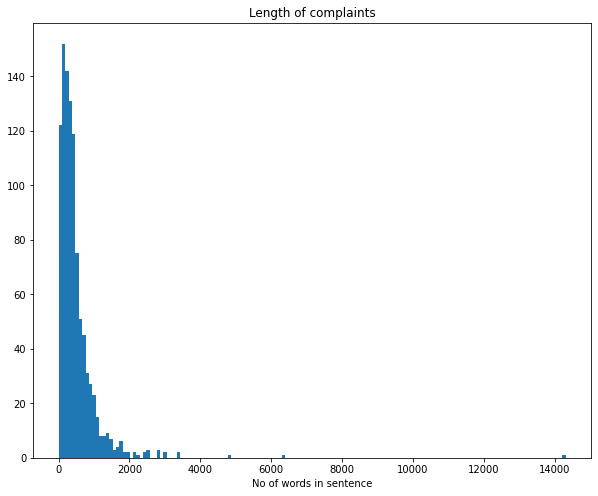

In [33]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len = [len(i) for i in df_clean['complaint_POS_removed']]
plt.figure(figsize=(10,8))
plt.hist(complaint_len,bins=150)
plt.xlabel('No of words in sentence')
plt.title('Length of complaints')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [34]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
comment_words = ""
for words in df_clean['complaint_POS_removed'].tolist():
    comment_words += words

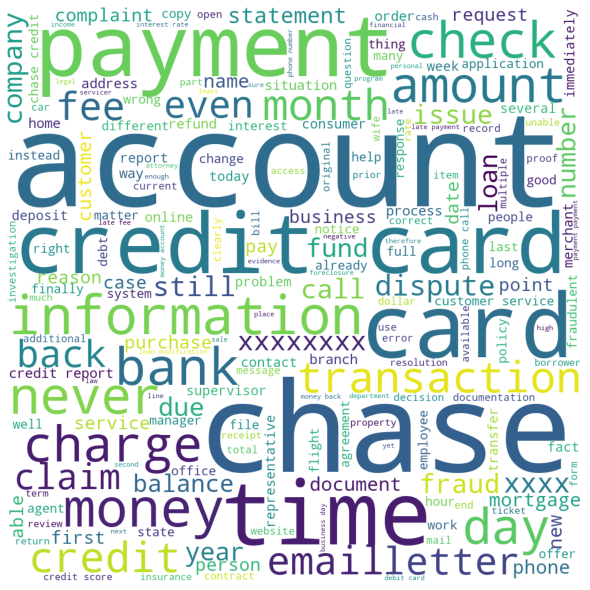

In [35]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def plotWordCloud(words):
    wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

#words = "Using a word cloud find the top 40 words by frequency among all the articles after processing the text"
plotWordCloud(comment_words)

In [36]:
df_clean['complaint_POS_removed'].head()

0    good morning name chase debt verification stat...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_POS_removed, dtype: object

In [37]:
# Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [38]:
df_clean['complaint_clean'].head()

0    good morning name chase debt verification stat...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [39]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigrams(corpus,n=None):
    vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
    return words_freq[:n]

def plot_ngrams(top10):
    x = pd.DataFrame(top10,columns=['ngram','count'])
    plt.figure(figsize=(15,10))
    sns.barplot(x=x['ngram'],y=x['count'])

get_top_n_unigrams(df_clean['complaint_clean'],n=30)

[('account', 2214),
 ('chase', 1748),
 ('credit', 1470),
 ('card', 1419),
 ('payment', 945),
 ('time', 767),
 ('money', 579),
 ('day', 557),
 ('charge', 545),
 ('information', 522),
 ('bank', 462),
 ('transaction', 460),
 ('number', 458),
 ('fee', 451),
 ('check', 440),
 ('month', 421),
 ('letter', 390),
 ('email', 370),
 ('customer', 368),
 ('report', 359),
 ('loan', 358),
 ('phone', 358),
 ('balance', 350),
 ('year', 342),
 ('service', 331),
 ('dispute', 329),
 ('company', 328),
 ('claim', 322),
 ('xxxx', 302),
 ('mortgage', 281)]

account
chase
credit
card
payment
time
money
day
charge
information


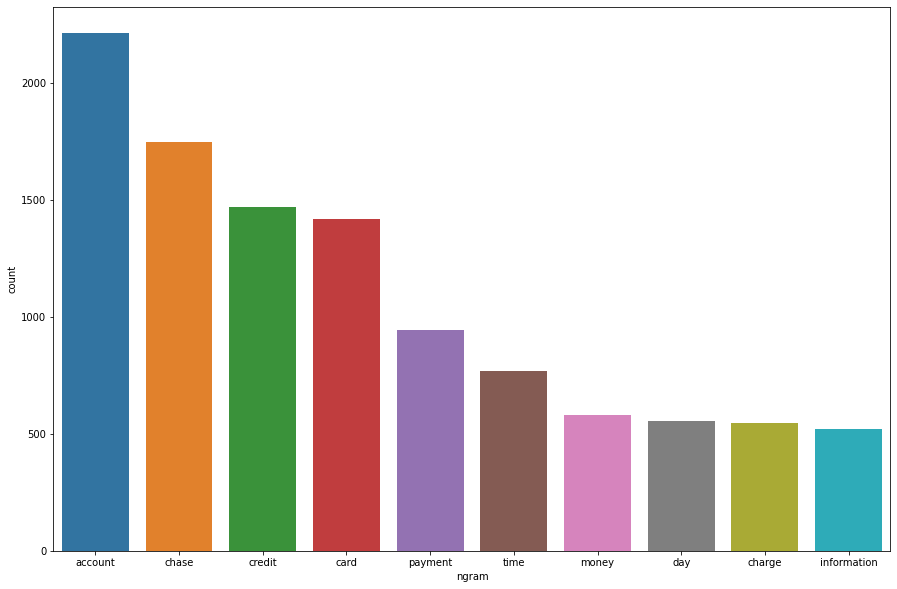

In [40]:
# Print the top 10 words in the unigram frequency
top_10_unigram = get_top_n_unigrams(df_clean['complaint_clean'], n=10)
for i in top_10_unigram:
    print(i[0])
plot_ngrams(top_10_unigram)

In [41]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_bigrams(df_clean['complaint_clean'], n=30)

[('credit card', 597),
 ('credit report', 178),
 ('customer service', 122),
 ('chase credit', 100),
 ('account account', 97),
 ('credit score', 79),
 ('payment payment', 76),
 ('card account', 76),
 ('debit card', 70),
 ('late payment', 69),
 ('money account', 68),
 ('account chase', 67),
 ('chase card', 66),
 ('chase account', 64),
 ('loan modification', 63),
 ('late fee', 63),
 ('business day', 62),
 ('phone number', 62),
 ('account credit', 59),
 ('card chase', 58),
 ('account number', 55),
 ('close account', 54),
 ('saving account', 54),
 ('police report', 51),
 ('bank account', 46),
 ('card company', 46),
 ('checking account', 46),
 ('fraudulent charge', 46),
 ('card credit', 45),
 ('branch manager', 43)]

credit card
credit report
customer service
chase credit
account account
credit score
payment payment
card account
debit card
late payment


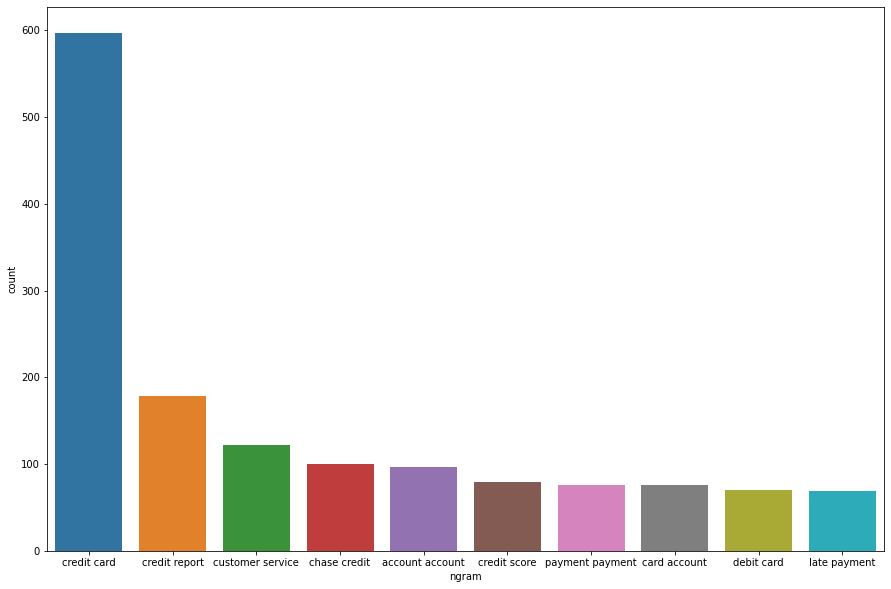

In [42]:
# Print the top 10 words in the bigram frequency
top_10_bigram = get_top_n_bigrams(df_clean['complaint_clean'], n=10)
for i in top_10_bigram:
    print(i[0])

plot_ngrams(top_10_bigram)

In [43]:
# Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_trigrams(df_clean['complaint_clean'], n=30)

[('chase credit card', 63),
 ('credit card account', 39),
 ('credit card company', 35),
 ('credit card chase', 32),
 ('credit card credit', 25),
 ('payment payment payment', 24),
 ('card credit card', 23),
 ('credit card number', 19),
 ('account credit report', 17),
 ('account credit card', 17),
 ('customer service representative', 16),
 ('credit report credit', 16),
 ('late payment credit', 15),
 ('social security number', 14),
 ('charge credit card', 14),
 ('chase customer service', 13),
 ('victim identity theft', 13),
 ('credit card statement', 13),
 ('new credit card', 12),
 ('credit card service', 11),
 ('credit card time', 10),
 ('payment late fee', 10),
 ('private client banker', 10),
 ('inquiry credit report', 10),
 ('credit card information', 10),
 ('payment credit report', 10),
 ('credit reporting agency', 10),
 ('vacant property registration', 10),
 ('unauthorized claim individual', 9),
 ('claim individual group', 9)]

chase credit card
credit card account
credit card company
credit card chase
credit card credit
payment payment payment
card credit card
credit card number
account credit report
account credit card


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

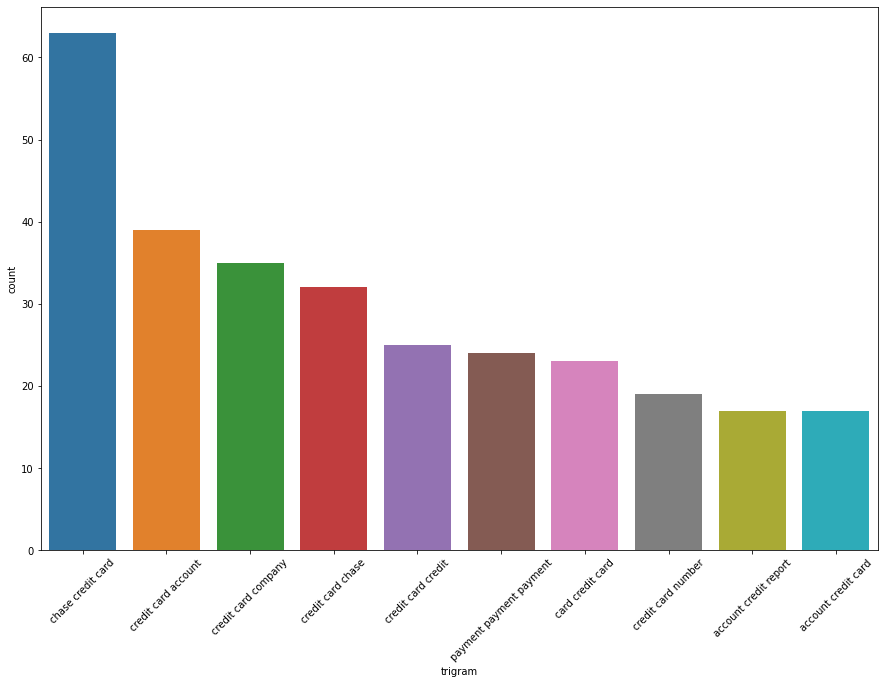

In [44]:
# Print the top 10 words in the trigram frequency
top_10_trigram = get_top_n_trigrams(df_clean['complaint_clean'], n=10)
for i in top_10_trigram:
    print(i[0])

x = pd.DataFrame(top_10_trigram,columns=['trigram','count'])
plt.figure(figsize=(15,10))
sns.barplot(x=x['trigram'],y=x['count'])
plt.xticks(rotation=45)

## Remove xxxx
The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [45]:
df_clean['complaint_clean'].head()

0    good morning name chase debt verification stat...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

In [46]:
# Test the regex on a samplt string
sub_word = re.sub('xxxx[x]*', '', "abc xxxx def xxxxx ghi xxxxxxxxx jkl");print(sub_word)
sub_word.replace('  ',' ')

abc  def  ghi  jkl


'abc def ghi jkl'

In [47]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx[x]*', '', regex=True)
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('  ', ' ')

In [48]:
# Remove chase which is the top most word which is the name of the bank
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('chase', '')

In [49]:
#All masked texts has been removed
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name chase debt verification stat...,good morning name debt verification statement...
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",card agent anniversary date agent wrong inform...,card agent anniversary date agent wrong inform...
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...,card however fraudulent application identity c...
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",son check account never money grand son clear ...,son check account never money grand son clear ...


In [50]:
df_clean['complaint_clean'].head()

0    good morning name  debt verification statement...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

In [51]:
comment_words = ""
for words in df_clean['complaint_clean'].tolist():
    comment_words += words

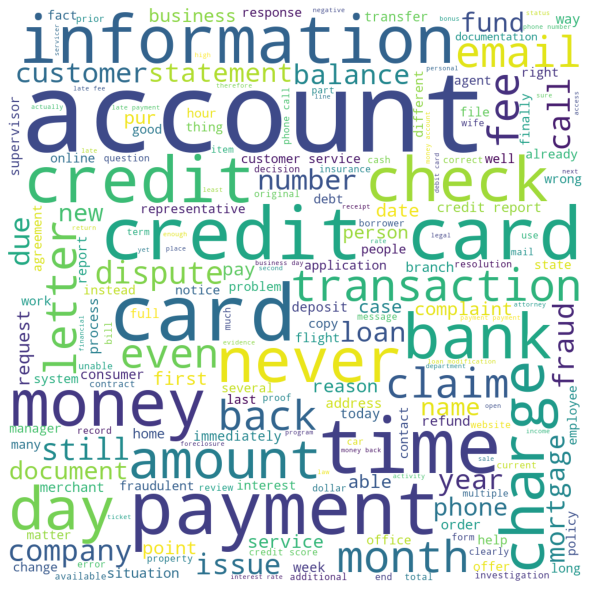

In [52]:
plotWordCloud(comment_words)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [53]:
df_clean['complaint_clean'].head()

0    good morning name  debt verification statement...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

In [54]:
# Write your code here to initialise the TfidfVectorizer 
#tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer()#max_df= 90 , min_df=10)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [55]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_clean'].tolist())
print(dtm)  

  (0, 1775)	0.16519292721516954
  (0, 3918)	0.25195749731552725
  (0, 798)	0.1730166477563968
  (0, 1968)	0.12366063365442236
  (0, 3388)	0.1730166477563968
  (0, 668)	0.27969662390894906
  (0, 2467)	0.12096143580996857
  (0, 2297)	0.17415722880441303
  (0, 2007)	0.1789945750448498
  (0, 4249)	0.3026365506152107
  (0, 366)	0.11917344862340361
  (0, 19)	0.27969662390894906
  (0, 3709)	0.15474516956184234
  (0, 4272)	0.23227695387885333
  (0, 969)	0.559506216013701
  (0, 2499)	0.1535783659760972
  (0, 2475)	0.22877530895289133
  (0, 1684)	0.16716419326521106
  (1, 773)	0.2572935243603286
  (1, 2655)	0.1670279246399423
  (1, 4410)	0.18551672952032244
  (1, 948)	0.28943065979933125
  (1, 197)	0.6453690277000325
  (1, 132)	0.5902497060942127
  (1, 542)	0.09104627583299056
  :	:
  (999, 2755)	0.24911642768727887
  (999, 2111)	0.21748179807038726
  (999, 1750)	0.22518575419660983
  (999, 1807)	0.22518575419660983
  (999, 3865)	0.20586520716576479
  (999, 561)	0.4349635961407745
  (999, 1867)	

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [56]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [57]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [58]:
# Document - Topic
W = nmf_model.fit_transform(dtm)
len(tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



4425

In [59]:
type(W), W.shape, W[:10]

(numpy.ndarray,
 (1000, 5),
 array([[0.01077899, 0.00739006, 0.03733989, 0.        , 0.05188346],
        [0.        , 0.02390948, 0.00516133, 0.        , 0.05272275],
        [0.        , 0.09105813, 0.        , 0.        , 0.03647946],
        [0.03503653, 0.11439865, 0.01614725, 0.00117549, 0.0307208 ],
        [0.09176047, 0.        , 0.00904609, 0.        , 0.02982652],
        [0.        , 0.10711535, 0.        , 0.        , 0.        ],
        [0.10687697, 0.        , 0.04550116, 0.03041169, 0.01308292],
        [0.01074381, 0.00217287, 0.14532337, 0.        , 0.02906073],
        [0.00706074, 0.        , 0.01386473, 0.        , 0.240567  ],
        [0.        , 0.23613848, 0.        , 0.        , 0.        ]]))

In [60]:
# Topic - Words
H = nmf_model.components_

In [61]:
type(H), H.shape, H[:10]

(numpy.ndarray,
 (5, 4425),
 array([[0.00554906, 0.00092453, 0.        , ..., 0.00381519, 0.00409204,
         0.        ],
        [0.00038896, 0.        , 0.        , ..., 0.        , 0.        ,
         0.00659063],
        [0.        , 0.        , 0.        , ..., 0.        , 0.01172019,
         0.00591282],
        [0.        , 0.        , 0.        , ..., 0.00239888, 0.        ,
         0.        ],
        [0.        , 0.00202909, 0.00307434, ..., 0.        , 0.        ,
         0.00412442]]))

In [62]:
#Print the Top15 words for each of the topics
TOP_WORDS = 15
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, TOP_WORDS)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(TOP_WORDS)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:TOP_WORDS]
    topic_words.iloc[i] = words[ix]

topic_words.to_csv("out.csv")
topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,check,money,deposit,fund,bank,branch,day,open,number,transfer,back,business,close,access
Topic 1,credit,card,report,inquiry,company,hard,account,application,score,year,limit,letter,point,month,also
Topic 2,payment,late,loan,mortgage,interest,due,time,month,year,modification,statement,home,amount,rate,credit
Topic 3,fee,overdraft,balance,charge,annual,late,transaction,account,interest,pur,card,pay,membership,year,month
Topic 4,transaction,charge,dispute,card,fraud,claim,information,merchant,email,fraudulent,number,service,letter,time,customer


In [63]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 0': 'Bank account services',
    'Topic 1': 'Credit card / Prepaid card',
    'Topic 2': 'Others',  # 'Mortgages/loans',
    'Topic 3': 'Theft/Dispute reporting',#'Others', 
    'Topic 4': 'Mortgages/loans',  #'Theft/Dispute reporting',
}

In [64]:
#Assign the best topic to each of the complaints in Topic Column

#df_clean['Topic'] = #write your code to assign topics to each rows.
df_W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)])
df_clean['Topic'] = df_W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
df_clean['Topic']

0                 Mortgages/loans
1                 Mortgages/loans
2      Credit card / Prepaid card
3      Credit card / Prepaid card
4           Bank account services
                  ...            
995               Mortgages/loans
996                        Others
997                        Others
998         Bank account services
999                        Others
Name: Topic, Length: 1000, dtype: object

In [65]:
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name chase debt verification stat...,good morning name debt verification statement...,Mortgages/loans
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",card agent anniversary date agent wrong inform...,card agent anniversary date agent wrong inform...,Mortgages/loans
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...,card however fraudulent application identity c...,Credit card / Prepaid card
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card / Prepaid card
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",son check account never money grand son clear ...,son check account never money grand son clear ...,Bank account services


In [66]:
df_clean.shape

(1000, 5)

In [67]:
#Print the first 5 Complaint for each of the Topics
df_clean_gp = df_clean.groupby('Topic').head(10)
df_clean_gp[['complaint_clean','Topic']].sort_values('Topic')

def showSampleComplaintsOfTopic(topic):
    print("Topic", topic)
    [print(complaint, "\n") for complaint in df_clean_gp[df_clean_gp['Topic']==topic]['complaint_clean'].values[0:10]]

In [68]:
showSampleComplaintsOfTopic('Bank account services')

Topic Bank account services
son check account never money grand son clear money pay son time call verify check owner country time date check number claim number 

card branch customer service representative account actually branch fund currently direct deposit place employment bank associate customer service representative fund additional business day branch yet actually account fund long present current statement business day date available bank teller  check fund left account currently unfortunately additional financial bind fee late rent late car payment short notice thing actually peace mind fact  situation grossly even bank teller inform account suspicious suspicious look reserve right close account time notice form document notice thing actually peace mind fact  situation grossly even bank teller inform account suspicious suspicious look reserve right close account time notice form document situation truly livelihood deal professionally 

 

bonus account direct deposit bonus day

In [69]:
showSampleComplaintsOfTopic('Credit card / Prepaid card')

Topic Credit card / Prepaid card
card however fraudulent application identity consent fraudulently service credit identity applicant 

ticket offer ticket reward card information offer screen decision immediately immediately notification screen representative application information offer even credit offer first account statement pur ticket explicitly absolutely longer interested account application representative later application explicit request proceed application contrary representative fact ahead open credit account name credit report  correct information credit report even ahead process application consent error 

inquiry 

credit card incorrectly datum credit report company issue 

several time fraudulent inquiry need call contact original creditor inquiry report several attempt able right person care issue matter many attempt fraudulent credit report legal action never kind iquiry matter 

senior citizen several company time share company misleading refund credit card unsuccef

In [70]:
showSampleComplaintsOfTopic('Mortgages/loans')

Topic Mortgages/loans
good morning name  debt verification statement acceptable bank validate debt instead mail month collect debt right information consumer thank help 

card agent anniversary date agent wrong information order anniversary date  consent agent 

payment online retailer  quick pay scam website confirmation product response inquiry order  information transaction refund retailer bank  secured message way transaction contact information message response original email informing transfer however website scam inquiry email team order well regard refund request consumer online technical support team number email situation claim department call information initiating transfer agent end quickly possible interrupt closing script contact number opportunity information right question word phrase use information system initially transaction customer service agent information transaction system bank app transaction line well understanding situation call second time agent information

In [71]:
showSampleComplaintsOfTopic('Others')

Topic Others
summer month experience decline income due employment therefore month payment company  almost year request payment extension never delinquent auto loan payment however month payment extension year situation representative supervisor avail lengthy discussion reason contractual reason denial therefore office  followup week later role help matter representative conference call handing request information request still policy change explanation representative letter explanation letter reason policy change cfpb help denial payment extension especially clear reason denial 

loan modification  mo behind payment aen always 

pur payment closing date statement statement outstanding pur balance previous month statement show pur prior however statement still balance promotional balance promotional balance difference apparently minimum payment  thought pur promotional balance first minimum payment payment excess minimum high interest rate balance first first time  financial law large 

In [72]:
showSampleComplaintsOfTopic('Theft/Dispute reporting')

Topic Theft/Dispute reporting
concern wrongly overdraft fee alert low balance unsuficent fee balance always immediatly transaction  always order overdraft fee call guideline overdrawft bank fault people money document  refund always way back refunded first place 

multiple time late order credit debit account late fee receipt screen positive balance deposit next morning multiple bounced check first time right deposit eastern time last time sure deposit stuff transaction maximize amount thing class action lawsuit exact thing 

occasion bank  multiple overdraft fee account way process charge account large item first account small item afterwards back thing balance charge bank order subsequently overdraft fee amount complain practice way large item important item house payment car bank practice onetime courtesy charge reverse order charge opinion well money people payday day 

overdrew account due error transaction overdraft fee stoppayment fee additionally payment fee many time fee total

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [73]:
# Create the dictionary of Topic names and Topics
Topic_names = { 'Bank account services'         : 'Bank Account services',
                'Credit card / Prepaid card'    : 'Credit card or prepaid card',
                'Theft/Dispute reporting'       : 'Theft/Dispute Reporting',
                'Mortgages/loans'               : 'Mortgage/Loan',
                'Others'                        : 'Others' }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [74]:
df_clean[['complaint_clean', 'Topic']].head(10)

,complaint_clean,Topic
0,good morning name debt verification statement...,Mortgage/Loan
1,card agent anniversary date agent wrong inform...,Mortgage/Loan
2,card however fraudulent application identity c...,Credit card or prepaid card
3,ticket offer ticket reward card information of...,Credit card or prepaid card
4,son check account never money grand son clear ...,Bank Account services
5,inquiry,Credit card or prepaid card
6,card branch customer service representative ac...,Bank Account services
7,summer month experience decline income due emp...,Others
8,payment online retailer quick pay scam websit...,Mortgage/Loan
9,credit card incorrectly datum credit report co...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [75]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services'         : 1,
                'Credit card or prepaid card'   : 2,
                'Theft/Dispute Reporting'       : 3,
                'Mortgage/Loan'                 : 4,
                'Others'                        : 5 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [76]:
df_clean[['complaint_clean', 'Topic']].head(10)

,complaint_clean,Topic
0,good morning name debt verification statement...,4
1,card agent anniversary date agent wrong inform...,4
2,card however fraudulent application identity c...,2
3,ticket offer ticket reward card information of...,2
4,son check account never money grand son clear ...,1
5,inquiry,2
6,card branch customer service representative ac...,1
7,summer month experience decline income due emp...,5
8,payment online retailer quick pay scam websit...,4
9,credit card incorrectly datum credit report co...,2


In [89]:
df_clean.Topic.isnull().sum()

0

In [77]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
from sklearn.model_selection import train_test_split
X = df_clean['complaint_clean']
y = df_clean['Topic']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)
X.shape, X_train.shape, X_test.shape
#training_data=

((1000,), (700,), (300,))

In [78]:
X_train.head()

420    contacted report card bit unusual entire syste...
278    balance jpmcb card negative impact credit repo...
218    help email ad open sapphire checking account u...
363    credit card use everyday pur intentionally low...
850    new next day account cash deposit  point home ...
Name: complaint_clean, dtype: object

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [79]:
#Write your code to get the Vector count
vec = CountVectorizer(ngram_range=(1,1)).fit(X_train)
bag_of_words = vec.transform(X_train)
print(bag_of_words.shape)
sum_of_words = bag_of_words.sum(axis=0)
words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
print(words_freq[:10])

(700, 3616)
[('account', 1472), ('card', 987), ('credit', 959), ('payment', 676), ('time', 523), ('money', 406), ('charge', 375), ('day', 362), ('information', 349), ('check', 345)]


In [80]:
#Write your code here to transform the word vector to tf-idf
tfidf = TfidfVectorizer().fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"X_train_tfidf.shape {X_train_tfidf.shape}, X_test_tfidf.shape {X_test_tfidf.shape}\n"\
        f"tfidf.vocabulary {len(list(tfidf.vocabulary_))}, {list(tfidf.vocabulary_)[0:10]}")

terms = tfidf.get_feature_names()
print(len(terms), terms[0:10])

X_train_tfidf.shape (700, 3616), X_test_tfidf.shape (300, 3616)
tfidf.vocabulary 3616, ['contacted', 'report', 'card', 'bit', 'unusual', 'entire', 'system', 'navigated', 'last', 'charge']
3616 ['aback', 'aberration', 'ability', 'able', 'abroad', 'abruptly', 'absent', 'absolute', 'absolutely', 'absolve']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [81]:
cv_vocab = [word for word, freq in words_freq]; print(len(cv_vocab), cv_vocab[0:10])
tfidf_vocab = list(tfidf.vocabulary_); print(len(tfidf_vocab),tfidf_vocab[0:10])
diff = set(cv_vocab)-set(tfidf_vocab);len(diff);list(diff)[0:10]

3616 ['account', 'card', 'credit', 'payment', 'time', 'money', 'charge', 'day', 'information', 'check']
3616 ['contacted', 'report', 'card', 'bit', 'unusual', 'entire', 'system', 'navigated', 'last', 'charge']


[]

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Utility functions

In [82]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(dt_classifier, category, X, y):
    print(f"{category} Accuracy : {percent(accuracy_score(y, dt_classifier.predict(X)), 1)}%")
    print(f"{category} Confusion Matrix:")
    print(confusion_matrix(y, dt_classifier.predict(X)))

### Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [84]:
X_train_log = X_train_tfidf.toarray()
y_train_log = y_train.toarray()

In [91]:
model = LogisticRegression(random_state=40)
logreg = model.fit(X_train_log,y_train)


In [94]:
X_test_log = X_test_tfidf.toarray()
logreg.predict_proba(X_test_log)



array([[0.24452284, 0.15136645, 0.0543994 , 0.41917277, 0.13053854],
       [0.08810959, 0.0775245 , 0.0358482 , 0.24730736, 0.55121035],
       [0.61739916, 0.05172432, 0.04102328, 0.20037224, 0.08948102],
       ...,
       [0.46534171, 0.12532551, 0.05602435, 0.24059958, 0.11270885],
       [0.03334022, 0.18243955, 0.03003829, 0.0329057 , 0.72127623],
       [0.0875357 , 0.08471317, 0.07011664, 0.62734447, 0.13029001]])

In [99]:
y_pred = logreg.predict(X_test_log)

In [100]:
y_pred

array([4, 5, 1, 3, 2, 5, 4, 5, 1, 1, 2, 2, 1, 4, 1, 4, 5, 4, 3, 2, 2, 1,
       2, 1, 1, 2, 2, 2, 2, 3, 4, 4, 1, 1, 5, 4, 3, 2, 1, 1, 4, 2, 5, 5,
       1, 5, 4, 4, 2, 5, 1, 4, 4, 1, 5, 4, 4, 5, 4, 1, 1, 1, 4, 5, 4, 5,
       4, 5, 4, 3, 5, 5, 1, 2, 4, 2, 3, 1, 1, 4, 1, 4, 1, 1, 5, 5, 5, 4,
       4, 1, 5, 1, 5, 1, 2, 4, 4, 1, 4, 4, 1, 2, 4, 4, 5, 4, 4, 5, 4, 4,
       5, 2, 5, 5, 2, 1, 5, 5, 1, 4, 5, 1, 4, 1, 4, 3, 4, 5, 3, 2, 2, 4,
       4, 1, 3, 1, 4, 2, 1, 5, 4, 2, 2, 4, 2, 5, 4, 4, 1, 4, 4, 3, 5, 4,
       4, 5, 1, 4, 1, 4, 4, 2, 1, 4, 3, 4, 2, 4, 2, 2, 4, 4, 2, 4, 4, 1,
       4, 4, 1, 4, 5, 2, 1, 1, 4, 4, 2, 5, 2, 1, 1, 2, 2, 5, 2, 1, 2, 5,
       2, 2, 1, 5, 2, 5, 2, 5, 4, 4, 2, 5, 1, 4, 4, 2, 4, 5, 4, 4, 2, 5,
       2, 2, 4, 5, 4, 4, 2, 3, 5, 5, 2, 1, 2, 4, 2, 1, 4, 2, 2, 2, 4, 4,
       4, 4, 5, 5, 2, 4, 2, 5, 4, 5, 4, 1, 5, 2, 5, 4, 4, 4, 5, 4, 3, 4,
       2, 2, 5, 4, 4, 5, 2, 4, 4, 1, 4, 5, 4, 5, 1, 4, 2, 4, 2, 5, 4, 5,
       3, 1, 1, 5, 4, 4, 1, 5, 5, 5, 5, 1, 5, 4])

In [98]:
y_test

249    4
353    5
537    1
424    3
564    2
      ..
193    5
838    5
974    1
203    5
425    4
Name: Topic, Length: 300, dtype: int64

In [101]:
#evaluate_model(dt_classifier, category, X, y)
evaluate_model(logreg, "TRAIN", X_train_log, y_train);print()
evaluate_model(logreg, "TEST", X_test_log, y_test);print()
print(classification_report(y_test,y_pred))

TRAIN Accuracy : 98.57%
TRAIN Confusion Matrix:
[[145   0   0   1   0]
 [  0 145   0   0   0]
 [  4   2  45   2   1]
 [  0   0   0 209   0]
 [  0   0   0   0 146]]

TEST Accuracy : 87.33%
TEST Confusion Matrix:
[[51  0  0  9  0]
 [ 2 58  0  5  2]
 [ 4  0 14  7  0]
 [ 0  0  0 76  1]
 [ 1  3  0  4 63]]

              precision    recall  f1-score   support

           1       0.88      0.85      0.86        60
           2       0.95      0.87      0.91        67
           3       1.00      0.56      0.72        25
           4       0.75      0.99      0.85        77
           5       0.95      0.89      0.92        71

    accuracy                           0.87       300
   macro avg       0.91      0.83      0.85       300
weighted avg       0.89      0.87      0.87       300



### Decision Tree

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

'''dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_tfidf, y_train)'''

'dt = DecisionTreeClassifier(max_depth=3, random_state=42)\ndt.fit(X_train_tfidf, y_train)'

In [105]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 4], #  5, 10] If 5 and 10 are included, the best estimator has depth of 10 and the interpretation of the model was difficult. So using only the values of 2,3 4
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [106]:
%%time
grid_search.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 589 ms, sys: 222 ms, total: 811 ms
Wall time: 5.46 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [107]:
df_score = pd.DataFrame(grid_search.cv_results_)
df_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017785,0.002236,0.001715,0.000206,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.514286,0.508571,0.520000,0.508571,0.512857,0.004738,26
1,0.025426,0.001177,0.001758,0.000407,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.525714,0.508571,0.520000,0.514286,0.517143,0.006389,22
2,0.017995,0.002348,0.003280,0.003132,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.525714,0.508571,0.514286,0.514286,0.515714,0.006227,24
3,0.020275,0.004774,0.002115,0.000394,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.525714,0.508571,0.514286,0.514286,0.515714,0.006227,24
4,0.018993,0.004748,0.001843,0.000167,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.514286,0.514286,0.508571,0.531429,0.517143,0.008571,22


In [108]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)

In [109]:
evaluate_model(dt_best, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(dt_best, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test, dt_best.predict(X_test_tfidf)))

TRAIN Accuracy : 68.29%
TRAIN Confusion Matrix:
[[ 99   9   0  25  13]
 [  2  98   0  39   6]
 [  6   2  15  28   3]
 [  9  11   0 172  17]
 [  1   5   6  40  94]]

TEST Accuracy : 61.67%
TEST Confusion Matrix:
[[31  3  0 15 11]
 [ 2 47  0 17  1]
 [ 5  0  5 15  0]
 [ 4  3  0 61  9]
 [ 1  8  2 19 41]]

              precision    recall  f1-score   support

           1       0.72      0.52      0.60        60
           2       0.77      0.70      0.73        67
           3       0.71      0.20      0.31        25
           4       0.48      0.79      0.60        77
           5       0.66      0.58      0.62        71

    accuracy                           0.62       300
   macro avg       0.67      0.56      0.57       300
weighted avg       0.66      0.62      0.61       300



In [110]:
df_fi = pd.DataFrame({"variables": terms, "feature importance": dt_best.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
752,credit,0.331885
2256,payment,0.273723
29,account,0.160324
503,check,0.138298
1231,fee,0.055596


In [111]:
df_clean['Topic'] = df_clean['Topic'].apply(lambda x: str(x))
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              1000 non-null   object
 1   complaint_lemma        1000 non-null   object
 2   complaint_POS_removed  1000 non-null   object
 3   complaint_clean        1000 non-null   object
 4   Topic                  1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [112]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

''' 'Bank Account services'   : 1, 'Credit card or prepaid card' : 2,
    'Theft/Dispute Reporting': 3, 'Mortgage/Loan'               : 4,    'Others' : 5 '''
from graphviz import Source
def get_dt_graph(dt_classifier, features):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True, feature_names=features, class_names=["1", "2", "3", "4", "5"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"15,25!"')
    return graph.create_png()

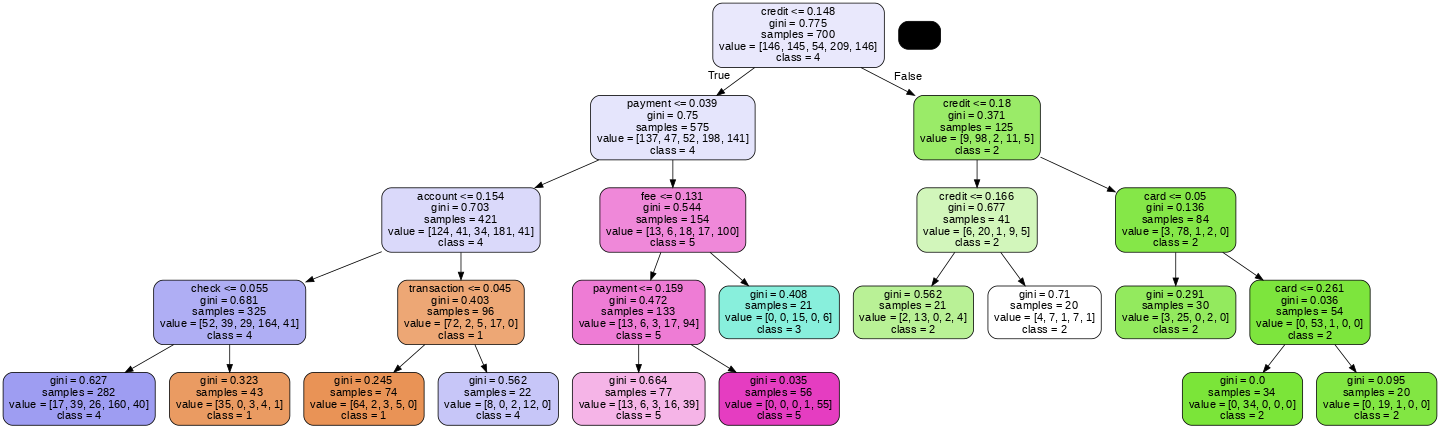

In [113]:
Image(get_dt_graph(dt_best, terms))

### Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3,oob_score=True)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [4, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [4, 8, 12],
    'n_estimators': [10, 30, 50, 100, 200]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, oob_score=True), param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [115]:
%%time
grid_search.fit(X_train_tfidf,y_train)

Fitting 4 folds for each of 225 candidates, totalling 900 fits
CPU times: user 9.33 s, sys: 535 ms, total: 9.86 s
Wall time: 3min 16s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 10], 'max_features': [4, 8, 12],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [116]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=5,
                       n_estimators=30, oob_score=True, random_state=42)

In [117]:
evaluate_model(rf_best, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(rf_best, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test, rf_best.predict(X_test_tfidf)))

TRAIN Accuracy : 53.29%
TRAIN Confusion Matrix:
[[ 30   1   0 114   1]
 [  0  70   0  73   2]
 [  0   2   0  47   5]
 [  0   0   0 209   0]
 [  0   0   0  82  64]]

TEST Accuracy : 43.0%
TEST Confusion Matrix:
[[ 7  0  0 53  0]
 [ 0 28  0 39  0]
 [ 0  0  0 25  0]
 [ 0  0  0 77  0]
 [ 0  4  0 50 17]]

              precision    recall  f1-score   support

           1       1.00      0.12      0.21        60
           2       0.88      0.42      0.57        67
           3       0.00      0.00      0.00        25
           4       0.32      1.00      0.48        77
           5       1.00      0.24      0.39        71

    accuracy                           0.43       300
   macro avg       0.64      0.35      0.33       300
weighted avg       0.71      0.43      0.38       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



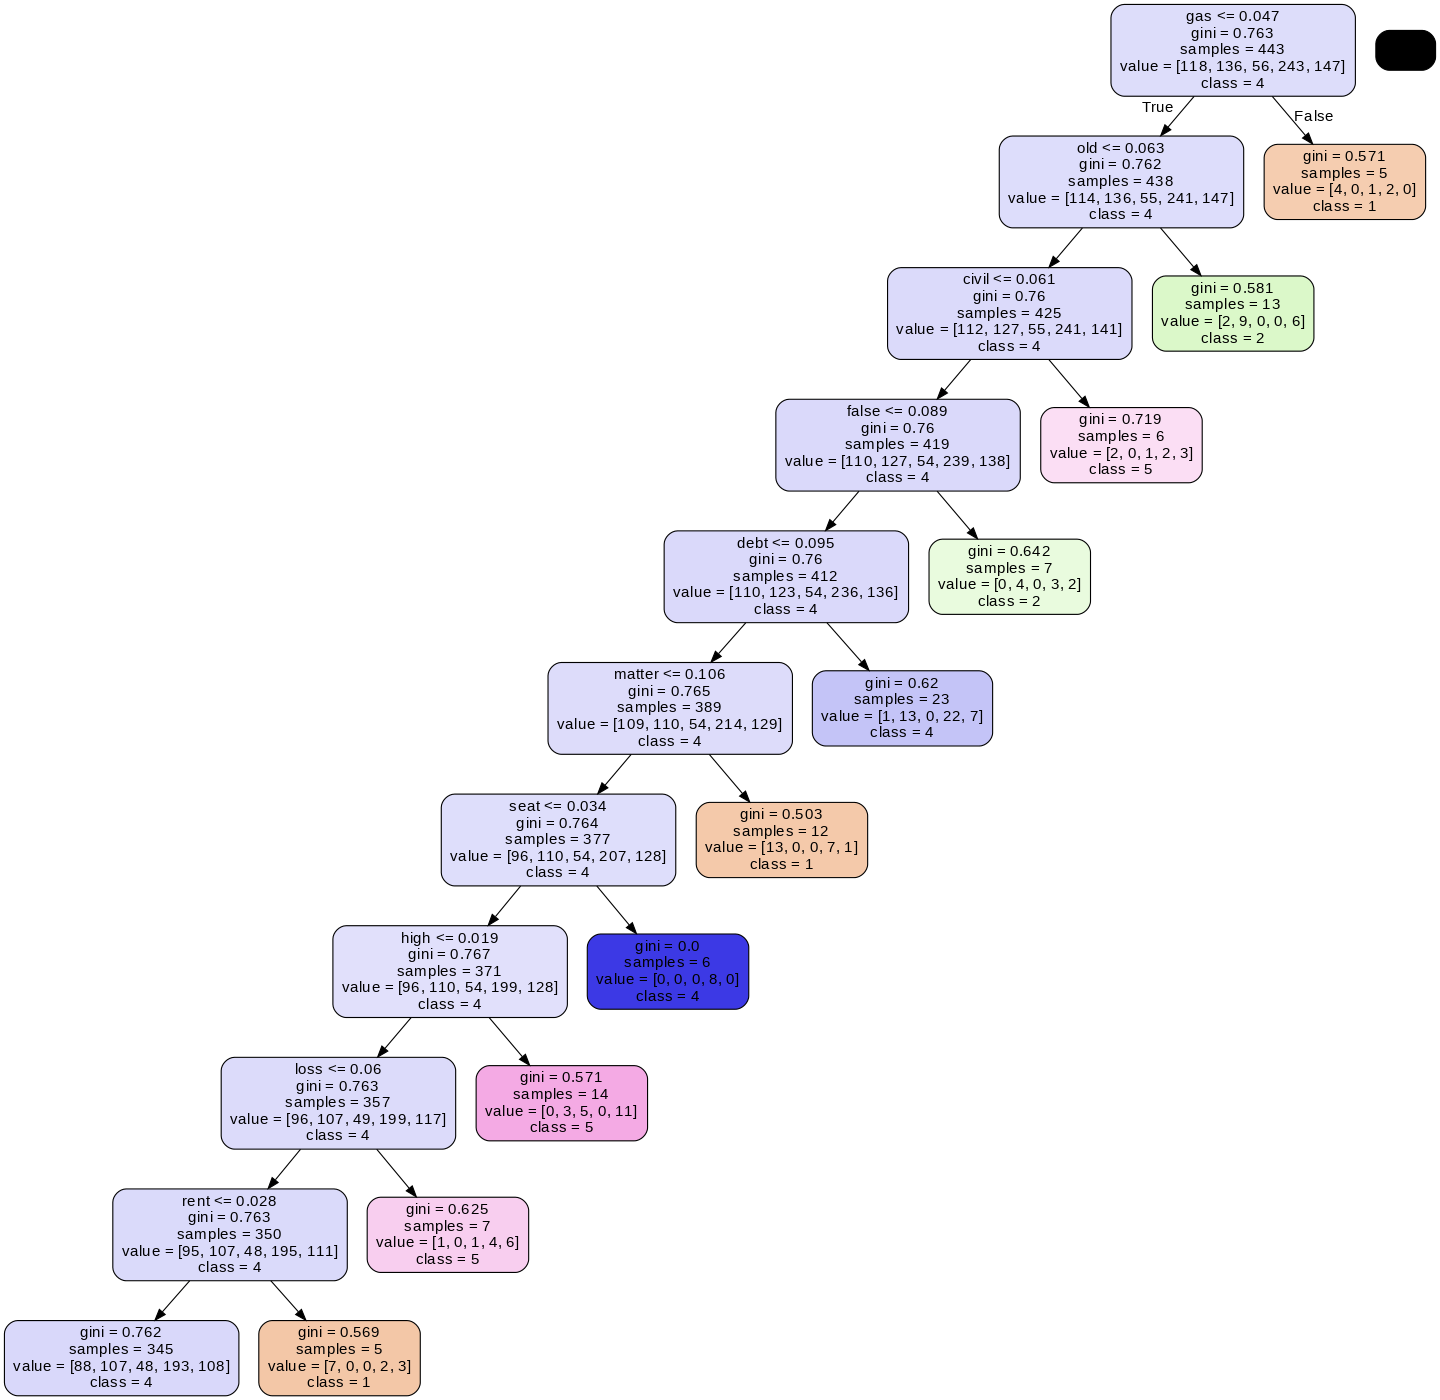

In [118]:
Image(get_dt_graph(rf_best.estimators_[0],terms), height=600, width=600)

In [119]:
rf_best.oob_score_*100

47.42857142857143

### Summary

| Classifier | TRAIN Accuracy | TEST Accuracy |
|---|---|---|
| LogisticRegression |98.57% | 87.33%|
| DecisionTreeClassifier(max_depth=4, min_samples_leaf=50) | 65.57% | 65.33% |
| RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=5,n_estimators=30, oob_score=True, random_state=42) |  51.71% | 45.33% |